# Van der Pol
Generación de datos mediante el sistema de vanderpol

$$
\frac{d^2 \psi}{dt^2} - \mu(1-\psi^2) \frac{d\psi}{dt} +\psi = 0
$$

no lineal, por lo general complicada de tratar, solo simulable

en forma bidimensional es posible ordenarse mejor:
$$
\dot \psi = \omega
$$

$$
\dot \omega = \mu(1-\psi^2) \omega -\psi 
$$

In [3]:
# algoritmo basico
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import numpy as np

from scipy.stats import uniform

[]

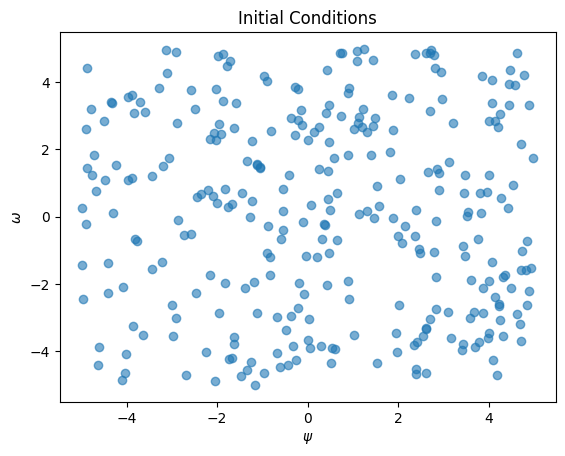

In [4]:
# condiciones iniciales aleatorias uniforme
max_psi = 5
max_omega = max_psi

n_particles = 300

psi = max_psi * 2 * ( uniform.rvs(size=n_particles) - 0.5 )
omega = max_psi * 2 * ( uniform.rvs(size=n_particles) - 0.5 )

Z_0 = np.array([psi,omega])

#---
fig, ax = plt.subplots(1, 1)
ax.scatter(psi, omega,
    alpha=0.6, label='uniform pdf')
ax.set_xlabel(r'$\psi$')
ax.set_ylabel(r'$\omega$')
ax.set_title('Initial Conditions')
plt.plot()

In [5]:
# Tiempo
t_span = (0, 40)  # Tiempo inicial y final
N_t = 300
t_eval = np.linspace(*t_span, N_t)  # Vector de tiempo

In [6]:
from functools import partial

def dZdt(_t, Z, mu):
    psi, omega = Z
    return [omega,
            mu * (1-psi**2) * omega - psi]

mu = 0.5

# esta linea permite argumentos extra
dZdt_with_mu = partial(dZdt, mu=mu)


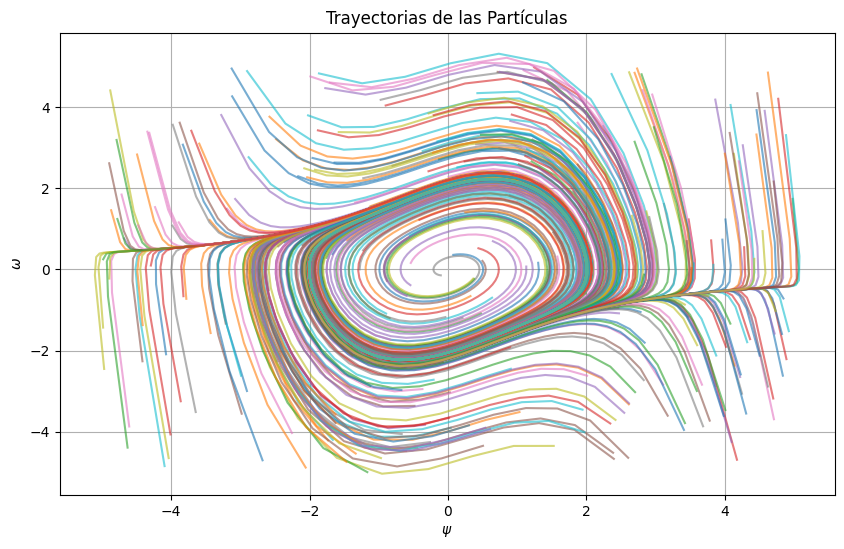

In [7]:
# Resolver la ecuación para cada partícula
solutions = []
for i in range(n_particles):
    sol = solve_ivp(dZdt_with_mu, t_span, Z_0[:, i], t_eval=t_eval, vectorized=True)
    solutions.append(sol.y)

# Graficar las trayectorias de las partículas
plt.figure(figsize=(10, 6))
for i in range(n_particles):
    plt.plot(solutions[i][0], solutions[i][1], alpha=0.6)


plt.xlabel(r'$\psi$')
plt.ylabel(r'$\omega$')
plt.title('Trayectorias de las Partículas')
plt.grid()
plt.show()

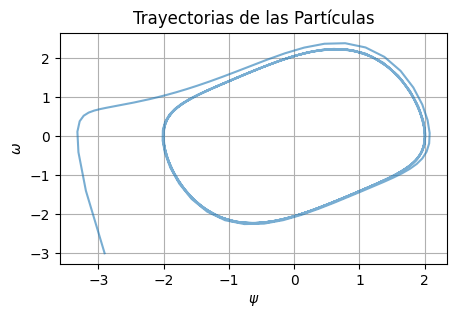

In [8]:
# Una sola particula
plt.figure(figsize=(5, 3))

i = 0
plt.plot(solutions[i][0], solutions[i][1], alpha=0.6)


plt.xlabel(r'$\psi$')
plt.ylabel(r'$\omega$')
plt.title('Trayectorias de las Partículas')
plt.grid()
plt.show()

In [9]:
# (particulas, [psi,omega], tiempos )
# (100,2,1000)
np.shape(solutions)

(300, 2, 300)

In [10]:
# Crear los datos
import h5py

# Suponiendo que `solutions` tiene las trayectorias de las partículas
# solutions tiene la forma (particulas, 2, tiempos)
data_file = "trayectorias.h5"

with h5py.File(data_file, "w") as hf:
    hf.create_dataset("trayectorias", data=solutions)

print("Datos guardados en", data_file)


Datos guardados en trayectorias.h5


In [11]:

# Leer los datos
import h5py
import tensorflow as tf

data_file = "trayectorias.h5"

with h5py.File(data_file, "r") as hf:
    solutions = hf["trayectorias"][:]

# Asegúrate de que las trayectorias se ajusten a tus necesidades específicas
# Si es necesario, puedes transformar los datos en tensores TensorFlow
solutions = tf.constant(solutions, dtype=tf.float32)

# Luego, puedes usar las trayectorias en TensorFlow para machine learning


# Generar Trayectorias de a Trios

In [12]:
import tensorflow as tf

# Supongamos que tienes tus datos en el tensor "solutions"
# Las dimensiones de solutions son (batch_size, num_variables, num_time_steps)
# En tu caso, batch_size=1000, num_variables=2, num_time_steps=800

# Obtén las posiciones (x) y velocidades (v) por separado
x = solutions[:, 0, :]  # Las posiciones están en la primera variable (0)
v = solutions[:, 1, :]  # Las velocidades están en la segunda variable (1)

# Define el tamaño de la ventana (3 en tu caso)
window_size = 3

# Genera las ventanas deslizantes para x
x_windows = [x[:, i:i+window_size] for i in range(x.shape[1] - window_size + 1)]

# Genera las ventanas deslizantes para v
v_windows = [v[:, i:i+window_size] for i in range(v.shape[1] - window_size + 1)]

# Convierte las listas de tensores en un solo tensor
x_windows = tf.stack(x_windows, axis=2)  # Resultado: (batch_size, window_size, num_windows)
v_windows = tf.stack(v_windows, axis=2)  # Resultado: (batch_size, window_size, num_windows)


In [13]:
# 1. Creamos un Dataset a partir de las trayectorias
dataset = tf.data.Dataset.from_tensor_slices(solutions)

# 2. Transformamos las trayectorias para obtener las ventanas de tamaño 3
def create_windows(trayectoria):
    # Creamos un Dataset para la posición 'x'
    ds_x = tf.data.Dataset.from_tensor_slices(trayectoria[0])
    ds_x = ds_x.window(3, shift=1, drop_remainder=True).flat_map(lambda x: x.batch(3))
    
    # Creamos un Dataset para la velocidad 'v'
    ds_v = tf.data.Dataset.from_tensor_slices(trayectoria[1])
    ds_v = ds_v.window(3, shift=1, drop_remainder=True).flat_map(lambda v: v.batch(3))
    
    return tf.data.Dataset.zip((ds_x, ds_v))

dataset = dataset.flat_map(create_windows)

# 3. Aplanamos el dataset
dataset = dataset.batch(1000).unbatch()

# Iteramos a través del dataset para obtener los datos
# for x, v in dataset:
#     print("x:", x.numpy())
#     print("v:", v.numpy())

In [14]:
dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.float32, name=None))

In [15]:
# Ahora puedes iterar sobre el dataset para leer los datos
print_n = 5
for data in dataset:
    print(data)
    print_n -= 1
    if print_n < 0:
        break
    

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.904083 , -3.1910958, -3.3053868], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.9946606 , -1.395541  , -0.40961367], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.1910958, -3.3053868, -3.3212361], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.395541  , -0.40961367,  0.11411361], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.3053868, -3.3212361, -3.2860441], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.40961367,  0.11411361,  0.38216385], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.3212361, -3.2860441, -3.2245622], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.11411361, 0.38216385, 0.5228566 ], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.2860441, -3.2245622, -3.1488047], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=fl

## Guardar un dataset

In [16]:
# Supongamos que ya tienes el dataset que deseas guardar (dataset en tu caso)
# Define la ruta del archivo TFRecord en la que se guardarán los datos
output_path = "dataset.tfrecord"

# Función para convertir un elemento del dataset a un ejemplo TFRecord
def serialize_dataset(x, v):
    feature = { 
        'x': tf.train.Feature(float_list=tf.train.FloatList(value=x)),
        'v': tf.train.Feature(float_list=tf.train.FloatList(value=v))
    }
    proto = tf.train.Example(features=tf.train.Features(feature=feature) )
    return proto.SerializeToString()

# Guardar el dataset en el archivo TFRecord
with tf.io.TFRecordWriter(output_path) as writer:
    for x, v in dataset:
        example = serialize_dataset(x, v)
        writer.write(example)

## Leer el data set

In [20]:
# Ruta del archivo TFRecord que deseas cargar
input_path = "dataset.tfrecord"

# Función para parsear un ejemplo TFRecord
def parse_dataset(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([3], tf.float32),
        'v': tf.io.FixedLenFeature([3], tf.float32)
    }
    dataset = tf.io.parse_single_example(example_proto, feature_description)
    return dataset['x'], dataset['v']

# Cargar el dataset desde el archivo TFRecord
dataset = tf.data.TFRecordDataset(input_path)
dataset = dataset.map(parse_example)

# Ahora puedes utilizar el dataset para entrenar tu modelo


NameError: name 'parse_example' is not defined